Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


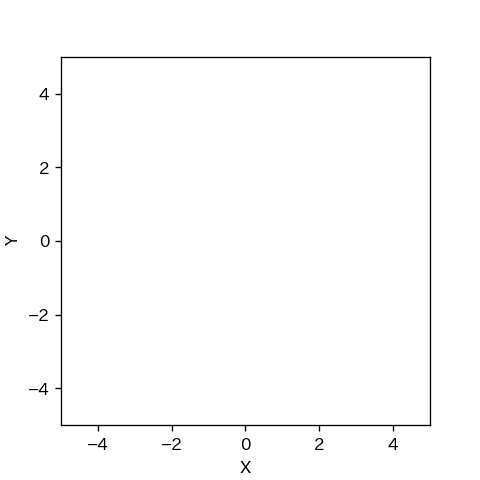

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs=np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id=observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p,self.map.landmarks[landmark_id].pos,*values)
            
        print(list([obs[0][0] for obs in observation]))
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

In [3]:
def trial_phantom_trap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([0,0,0]).T
    robot_pose=np.array([0,0,0]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m, phantom_prob=0.1),agent=a,color="red",expected_stuck_time=5,expected_escape_time=5)
    world.append(r)
#  phantom_prob=0.1
    world.draw()
    return(r.pose,pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


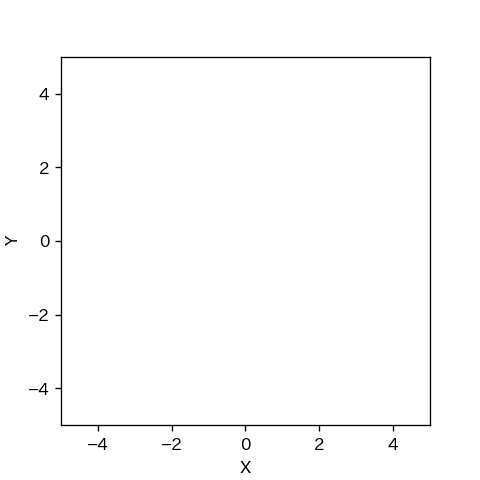

(array([0, 0, 0]), array([0, 0, 0]))

In [4]:
trial_phantom_trap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_phantom_trap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

0 真値: [0.89754136 2.43071932 2.50731581] 推定値: [0.4255383  4.44054033 2.70543658] 誤差: 2.0645017242839576
1 真値: [1.42819712 1.94150451 2.06361551] 推定値: [0.70191104 1.99834456 2.92994454] 誤差: 0.7285068684681602
1
2 真値: [0.98013891 0.59205896 1.1299247 ] 推定値: [2.00372732 0.58460576 1.47851391] 誤差: 1.023615542603756
3 真値: [1.0142111  1.88287735 2.07582596] 推定値: [1.03334276 1.46556228 2.02162059] 誤差: 0.4177533856511619
2
4 真値: [0.62386561 2.30422011 2.90846568] 推定値: [0.48893037 2.56811529 2.92050218] 誤差: 0.29639194620335296
3
5 真値: [0.04346802 1.78714647 3.15617427] 推定値: [-1.70826806  4.08863136  3.88149468] 誤差: 2.8923021968837093
6 真値: [0.1518065  2.95708598 2.98238246] 推定値: [-0.24075386  4.04728637  3.28710139] 誤差: 1.1587236589098273
[5.117872615915291]
7 真値: [0.83627638 2.25409919 2.46324661] 推定値: [ 0.0678398   3.65001872 -3.53506475] 誤差: 1.593451003808253
8 真値: [-1.2576578   1.05007345  4.67015239] 推定値: [-0.99297561  1.10673067  4.64547078] 誤差: 0.2706782196536869
4
9 真値: [ 0.1937371  -0.

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [0.36098287 1.7394233  2.69244457] 推定値: [-0.69048022  4.65892075  3.39818049] 誤差: 3.103069449399083
21 真値: [0.65358368 2.08472378 2.79917075] 推定値: [0.38892536 2.54807934 2.97208811] 誤差: 0.5336125922393388
13
22 真値: [-0.51567613  2.08562088  3.6385996 ] 推定値: [-0.52446438  2.51081623  3.67587932] 誤差: 0.4252861561134317
14
23 真値: [-0.17498143  2.15087203  3.29686583] 推定値: [0.35162346 3.45757868 3.65611022] 誤差: 1.4088275140233177
24 真値: [-1.20165006  0.4383927   4.98399172] 推定値: [-1.46495278  0.23213099  5.0374955 ] 誤差: 0.3344730376048464
15
25 真値: [0.14480649 2.49226515 3.45777165] 推定値: [-0.20901904  1.92002514  3.24907319] 誤差: 0.6727935328813717
16
26 真値: [1.50793261 0.55993058 0.87712862] 推定値: [2.19582648 0.47219669 1.09323366] 誤差: 0.6934660907874708
17
27 真値: [-1.25824616  1.3162881   4.63873899] 推定値: [-0.63006938  1.83835654  4.53815729] 誤差: 0.8167995624511458
18
28 真値: [-0.31880735  2.39647952  3.7660027 ] 推定値: [-0.83010611  2.32682818  3.70560191] 誤差: 0.5160210552090919
19
29